# 06. 피마 인디언 당뇨병 예측
- 북아메리카 피마 지역 우너주민의 Type-2 당뇨병 결과 데이터
- 서구화된 식습관으로 인한 많은 당뇨 환자 발생
- Pregnancies : 임신횟수
- Glucose : 포도당 부하 검사 수치
- BloodPressure : 혈압(mm Hg)
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- Insuline : 혈청 인슐린(mu U/ml)
- BMI : 체질량지수((체중kg)/(키m))^2
- DiabetesPedigreeFuncion : 당뇨 내력 가중치 값
- Age : 나이
- Outcome : 클래스 결정값(0또는1)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('Data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- 총 768개의 데이터
- negative값(0) : 500개
- positive값(1) : 268개

In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- null값 없음
- 피처의 타입 모두 숫자형

### 로지스틱 회귀 예측 모델 생성

In [18]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [10]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# train_test_split()파라미터 값
# arrays : 분할시킬 데이터를 입력 (Python list, Numpy array, Pandas dataframe 등..)
#test_size : 테스트 데이터셋의 비율(float)이나 갯수(int) (default = 0.25)
#train_size : 학습 데이터셋의 비율(float)이나 갯수(int) (default = test_size의 나머지)
#random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 (int나 RandomState로 입력)
#shuffle : 셔플여부설정 (default = True)
#stratify : 지정한 Data의 비율을 유지

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도:0.7727, 정밀도:0.7111, 재현율:0.5926,F1:0.6465, AUC:0.8083


- 전체 데이터의 65%가 negative이므로 정확도보다는 재현율 성능에 초점

In [11]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    #threshold 값 X축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

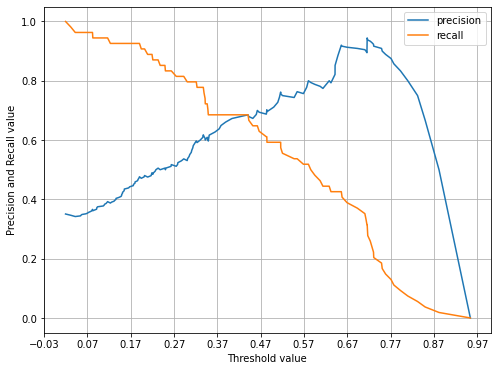

In [12]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임곗값 0.42로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같다.
- 하지만 두 개의 지표 모두 0.7이 안되는 수치로 보인다.
- 여전히 두 지표의 값이 낮음

In [13]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min( )값이 0으로 돼 잇는 피처가 많다.

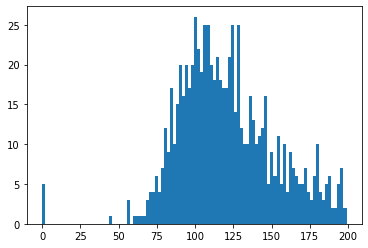

In [14]:
plt.hist(diabetes_data['Glucose'],bins=100)
plt.show()

- min( )값이 0으로 돼 있는 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인
- 확인할 피처 : 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', "BMI'

In [15]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features : 
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0건수는 5, 퍼센트는 0.65%
BloodPressure 0건수는 35, 퍼센트는 4.56%
SkinThickness 0건수는 227, 퍼센트는 29.56%
Insulin 0건수는 374, 퍼센트는 48.70%
BMI 0건수는 11, 퍼센트는 1.43%


- Insulin, SkinThickness 0값 많다.
- 전체 데이터 수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어려우므로
- 피처의 평균값으로 대체

In [16]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

- 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다.

In [19]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, AUC:0.8433


- 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됨

In [22]:
# 임곗값을 변화시키면서 재현율과 다른 평가 지표의 값 변화 추이

from sklearn.preprocessing import Binarizer
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [28]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3


/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [29]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

#위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931, AUC:0.8433
